In [121]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing as pre

import csv
import plotly.graph_objects as go
import plotly.express as px
import statistics
from scipy import stats

from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
%run svr_hosp_func.ipynb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import random
from scipy.stats import uniform

In [122]:
weekly_data=pd.read_csv('~/Desktop/thesis code/thesis/weekly_data.csv',parse_dates=['week'])
daily_data=pd.read_csv('~/Desktop/thesis code/thesis/daily_all_data.csv', parse_dates=['date'])

In [123]:
# use week dates as index number
weekly_data.index = weekly_data['week']
weekly_data = weekly_data.drop(['week'], axis=1)
weekly_data=weekly_data[['stringency_index','temp', 'windspeed', 'new_cases','new_deaths', 'icu_patients', 'hosp_patients','reproduction_rate', 'case_fatality', 'precip', 'humidity' ]]
weekly_data.humidity=weekly_data.humidity/100
weekly_data

,stringency_index,temp,windspeed,new_cases,new_deaths,icu_patients,hosp_patients,reproduction_rate,case_fatality,precip,humidity
week,,,,,,,,,,,
2020-03-30,78.70,7.780000,25.920000,5208.00,731.0,6478.0,13123.0,0.141015,0.140361,0.329800,0.676400
2020-04-06,78.70,12.671429,19.157143,7773.00,976.0,9791.0,19114.0,0.128903,0.125563,0.152714,0.639429
2020-04-13,78.70,9.585714,24.142857,6871.00,948.0,8790.0,16239.0,0.137014,0.137971,0.069429,0.647000
2020-04-20,78.70,12.314286,25.985714,4847.00,794.0,7159.0,13462.0,0.165101,0.163813,0.000000,0.558286
2020-04-27,78.70,10.642857,26.528571,2527.00,581.0,5484.0,10583.0,0.240214,0.229917,2.716429,0.795429
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,11.11,11.685714,29.442857,33639.00,36.0,288.0,6355.0,0.001105,0.001070,2.516571,0.838000
2022-11-07,11.11,11.171429,26.842857,23442.00,25.0,262.0,5174.0,0.001068,0.001066,3.349286,0.862857
2022-11-14,11.11,6.557143,26.114286,19641.25,22.0,228.0,4506.0,0.001102,0.001120,3.822571,0.889286


In [124]:
daily_data.index = daily_data['date']
daily_data =daily_data.drop(['date'], axis=1)
daily_data=daily_data[['stringency_index','temp', 'windspeed', 'new_cases','new_deaths', 'icu_patients', 'hosp_patients','reproduction_rate', 'case_fatality', 'precip', 'humidity' ]]
daily_data.humidity=daily_data.humidity/100
daily_data

,stringency_index,temp,windspeed,new_cases,new_deaths,icu_patients,hosp_patients,reproduction_rate,case_fatality,precip,humidity
date,,,,,,,,,,,
2020-04-01,78.70,3.8,17.2,1093.00,135.0,1208.000000,2945.0,0.123513,0.123513,0.000,0.764
2020-04-02,78.70,7.4,33.8,1028.00,166.0,1249.000000,2807.0,0.161479,0.161479,0.115,0.762
2020-04-03,78.70,7.0,26.7,909.00,149.0,1276.000000,2531.0,0.163916,0.163916,1.534,0.773
2020-04-04,78.70,8.2,21.0,1224.00,166.0,1360.000000,2570.0,0.135621,0.135621,0.000,0.598
2020-04-05,78.70,12.5,30.9,954.00,115.0,1385.000000,2270.0,0.120545,0.120545,0.000,0.485
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-26,11.11,7.3,21.6,2510.25,0.0,32.333333,583.0,0.000000,0.000000,0.000,0.936
2022-11-27,11.11,6.7,24.6,2573.50,0.0,32.666667,585.0,0.000000,0.000000,1.120,0.918
2022-11-28,11.11,8.5,17.2,2636.75,0.0,33.000000,587.0,0.000000,0.000000,9.841,0.981


In [125]:
weekly_hosp=XY_ICU(weekly_data)
daily_hosp=XY_ICU(daily_data)

In [126]:
#X_week=weekly_hosp.drop(['hosp_patients_shift'], axis=1)
X_week=weekly_hosp.drop(['icu_patients_shift'], axis=1)
Y_week=pd.DataFrame(weekly_hosp['icu_patients_shift'])

X_day=daily_hosp.drop(['icu_patients_shift'], axis=1)
Y_day=pd.DataFrame(daily_hosp['icu_patients_shift'])

In [127]:
X_weekinput=X_week.iloc[0:X_week.shape[0]-4,]
Y_weekinput=Y_week.iloc[0:Y_week.shape[0]-1,]

X_dayinput=X_day.iloc[0:X_day.shape[0]-4,]
Y_dayinput=Y_day.iloc[0:Y_day.shape[0]-1,]

# weekly

In [108]:
# Create the parameter grid: gbm_param_grid 
svr_param = {
    'epsilon': uniform(0.001, 0.1),
    'gamma': uniform(0.001, 0.1),
    'C': [1,5,10,15,20],
}

svr = SVR(kernel='rbf')


time_split = TimeSeriesSplit(n_splits = 10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(param_distributions = svr_param, estimator = svr, scoring = "neg_mean_squared_error", n_iter =100, cv=time_split, verbose = 1)

# Fit randomized_mse to the data
randomized_mse.fit(X_week, Y_week)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'C': 10, 'epsilon': 0.002201761338719387, 'gamma': 0.027580024358697965}
Lowest RMSE found:  1960.0619630405397


In [93]:
train_size=40
model_inputsize=2
forecast_steps=4
num_var=X_weekinput.shape[1]
kernel='rbf'
list1=['temp', 'windspeed', 'new_cases','new_deaths', 'icu_patients', 'hosp_patients' ]
list2=['reproduction_rate', 'case_fatality',  'precip', 'humidity']

scale=StandardScaler()
X_testsize=1
df_week=[]
model_predictions_week=[]
C= [1,5,10,15,20]
eps=[0.001, 0.005, 0.01, 0.03, 0.05, 0.1]
gamma=[0.001, 0.005,0.01,0.03, 0.05, 0.1]
for i in range(len(C)):
    for j in range(len(eps)):
        for k in range(len(gamma)):   
            predictions=traininng_sliding_window(scale,X_weekinput,Y_weekinput, train_size, model_inputsize,forecast_steps, list1, list2, num_var,'rbf',C[i],eps[j], gamma[k], X_testsize)
            dayt=[]
            dayt1=[]
            dayt2=[]
            dayt3=[]
            for n in range(len(predictions)):
                predictions[n]
                dayt.append(predictions[n][0][0])
                dayt1.append(predictions[n][1][0])
                dayt2.append(predictions[n][2][0])
                dayt3.append(predictions[n][3][0])
           # model_predictions_week.append(dayt)   
       
            #rmse_test=rmse(Y_weekinput.iloc[train_size+model_inputsize-1:-3,:].hosp_patients_shift.values,dayt)
            rmse=sqrt(mean_squared_error(Y_weekinput.iloc[train_size+model_inputsize-1:-3,:].icu_patients_shift.values, dayt))
            r2=r2_score(Y_weekinput.iloc[train_size+model_inputsize-1:-3,:].icu_patients_shift.values,dayt)
            mae_test=np.mean(np.abs(Y_weekinput.iloc[train_size+model_inputsize-1:-3,:].icu_patients_shift.values -  dayt))
            mape_test=mape(Y_weekinput.iloc[train_size+model_inputsize-1:-3,:].icu_patients_shift.values,dayt)
            df_week.append([C[i],eps[j],gamma[k], dayt, dayt1, dayt2, dayt3,Y_weekinput.iloc[train_size+model_inputsize-1:-3,:].icu_patients_shift.values, mape_test, rmse, mae_test, r2])
            #rmse_array.append([C[i],eps[j],gamma[k], rmse_test, mape_test])
    #mape_array.append(mape(Y_input.iloc[train_size+model_inputsize-1:-3,:].values,dayt))
    

In [36]:
table_week=pd.DataFrame(df_week)
table_week.columns=['C','epsilon','gamma,','weekt', 'weekt1','weekt2','weekt3','actual', 'mape_weekt', 'rmse','mae','R2']
table_week=table_week.sort_values(by=[ 'rmse', 'mape_weekt','mae', 'R2'],  ascending=True)
table_week.head(10)

# 1: 0.185116	209.022341	157.114819	0.965946
# 2: 0.195383	245.612898	177.154746	0.953665
# 3: 0.209970	272.261890	193.005818	0.943890
#

,C,epsilon,"gamma,",weekt,weekt1,weekt2,weekt3,actual,mape_weekt,rmse,mae,R2
164,20,0.030,0.010,"[5417.160548631958, 5408.189742913497, 5115.62...","[5563.186866310181, 5002.052063943916, 4591.26...","[5352.120829095178, 4596.878115812689, 4217.49...","[5033.664094162383, 4455.698111652603, 3781.25...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.175192,325.163960,240.237230,0.965352
158,20,0.010,0.010,"[5393.150075113684, 5392.9568069331, 5137.4298...","[5373.261420471139, 4944.205572722492, 4542.28...","[5027.440927884361, 4604.757826727469, 4194.71...","[4955.11946264208, 4416.451821503439, 3772.613...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.155858,326.419277,238.772308,0.965084
146,20,0.001,0.010,"[5416.955070623764, 5377.948225428843, 5193.12...","[5407.053341947132, 4864.982490546583, 4505.30...","[4998.014246726505, 4575.111173977906, 4178.60...","[5020.645658426894, 4395.519943931473, 3793.89...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.156690,328.481093,239.913466,0.964642
152,20,0.005,0.010,"[5418.178894116256, 5386.164415572714, 5165.50...","[5387.7511071238205, 4893.656481950529, 4519.5...","[5005.134593339477, 4593.942045114822, 4184.27...","[4991.166682984853, 4401.909042796866, 3781.30...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.156287,328.660203,240.257336,0.964603
145,20,0.001,0.005,"[5595.7915553314315, 5623.610078463058, 5168.0...","[5525.561832074374, 5026.441193795297, 4667.54...","[5408.761322839654, 4752.057597464425, 4185.72...","[5220.778153607918, 4574.820848028137, 3756.31...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.151530,329.256896,235.944885,0.964474
151,20,0.005,0.005,"[5577.491142251716, 5637.936377249201, 5162.20...","[5518.015251594513, 5038.605372681404, 4657.23...","[5389.546431021222, 4747.545338038198, 4182.17...","[5220.804709516593, 4588.438161797502, 3757.03...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.149442,329.996709,236.123646,0.964314
128,15,0.030,0.010,"[5508.313063635036, 5436.464735410369, 5147.05...","[5535.494944001131, 5054.699893662297, 4607.73...","[5323.124750365225, 4637.298034246153, 4182.58...","[5212.809710986348, 4487.147498206557, 3815.10...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.176464,331.795925,245.123415,0.963924
157,20,0.010,0.005,"[5560.780002502539, 5690.487372524325, 5179.10...","[5495.015176220806, 5056.67990031579, 4645.252...","[5368.653021727329, 4745.480450264178, 4137.88...","[5216.530023785739, 4609.08798917362, 3765.647...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.149225,332.100248,236.668213,0.963858
122,15,0.010,0.010,"[5513.512519372753, 5433.1257639706755, 5176.6...","[5423.07336893279, 4956.0931094608695, 4558.11...","[5193.922176482111, 4627.715002622441, 4185.85...","[5131.259861900131, 4481.148375181458, 3739.58...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.159659,332.143080,242.808233,0.963849
163,20,0.030,0.005,"[5633.457152980382, 5646.471051784743, 5219.52...","[5533.246732639339, 5134.888819961186, 4556.40...","[5458.891511484206, 4773.759547978298, 4147.64...","[5248.045746253349, 4678.950522466419, 3802.62...","[4981.0, 4827.0, 4756.0, 4579.0, 4138.0, 3764....",0.159464,332.859859,239.406292,0.963693


In [38]:
table_week2=pd.DataFrame(df_week)
table_week2.columns=['C','epsilon','gamma,','weekt', 'weekt1','weekt2','weekt3','actual', 'mape_weekt', 'rmse','mae','R2']
table_week2=table_week2.sort_values(by=[ 'rmse', 'mape_weekt','mae', 'R2'],  ascending=True)
table_week2.head(10)

,C,epsilon,"gamma,",weekt,weekt1,weekt2,weekt3,actual,mape_weekt,rmse,mae,R2
145,20,0.001,0.005,"[6119.578660766518, 4892.476068058802, 4538.42...","[5624.794454899426, 4452.021433417767, 4603.06...","[5166.1263685477925, 4166.546175605261, 4091.2...","[4897.139124849733, 3765.211161182299, 3521.60...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.204715,388.469411,279.488653,0.949445
151,20,0.005,0.005,"[6151.907403205587, 4904.245893115797, 4555.98...","[5630.549999597565, 4445.003356917069, 4582.08...","[5170.324924673155, 4171.2236074990815, 4086.2...","[4918.1282807036605, 3770.63872016363, 3512.26...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.205933,390.476801,281.176349,0.948921
109,15,0.001,0.005,"[6068.372338617595, 4934.7368269280105, 4553.7...","[5589.257845612657, 4539.906513605689, 4594.97...","[5224.834094408401, 4188.25783248908, 3997.554...","[4995.540893070955, 3793.005049119938, 3525.52...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.205474,390.833519,282.290486,0.948828
157,20,0.010,0.005,"[6164.013267795836, 4922.866885189571, 4566.80...","[5635.732721619892, 4435.910991922053, 4568.05...","[5185.94957329726, 4176.237442703395, 4087.660...","[4941.9301929569965, 3783.845242992038, 3497.7...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.207466,392.442409,283.800197,0.948406
115,15,0.005,0.005,"[6098.75636722795, 4954.7659214110445, 4562.06...","[5607.622874542383, 4537.6812564230195, 4589.8...","[5238.509554510017, 4182.073043687655, 4018.82...","[5014.929833470438, 3797.746595801689, 3510.56...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.206622,392.622827,284.091108,0.948358
121,15,0.010,0.005,"[6136.1279729234, 4981.8471217711285, 4581.504...","[5628.646362444333, 4532.912404097311, 4570.56...","[5249.24490830381, 4201.865521834921, 4049.630...","[5036.726205343291, 3801.2935248897547, 3498.6...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.206856,395.268155,286.191881,0.947660
73,10,0.001,0.005,"[5987.466873758496, 5124.141151215779, 4683.52...","[5471.343037372398, 4628.877952940229, 4617.64...","[5280.692086524536, 4234.114792470059, 3988.93...","[5093.2878414951865, 3840.455101915004, 3494.3...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.209632,397.814425,290.680993,0.946984
79,10,0.005,0.005,"[6020.902887892827, 5141.857985355728, 4675.74...","[5492.209049006557, 4631.5541140139885, 4601.4...","[5292.554965320818, 4243.048581273179, 3999.33...","[5104.2771612754, 3849.9854811056084, 3499.898...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.209725,399.673840,291.987832,0.946487
127,15,0.030,0.005,"[6186.215370954873, 5048.87420600636, 4557.762...","[5606.162474169247, 4545.332460049876, 4503.69...","[5299.105061500066, 4272.299230138386, 4064.25...","[5017.021125388775, 3861.8822291072997, 3456.7...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.213640,401.302560,293.105173,0.946050
163,20,0.030,0.005,"[6269.11862504791, 4991.817688331537, 4551.107...","[5672.939912203467, 4487.955829616079, 4491.11...","[5300.6816414305895, 4261.858993472206, 4081.4...","[4928.465057676271, 3846.183563398123, 3454.53...","[4827.0, 4756.0, 4579.0, 4138.0, 3764.0, 3671....",0.214214,401.515462,292.755019,0.945993


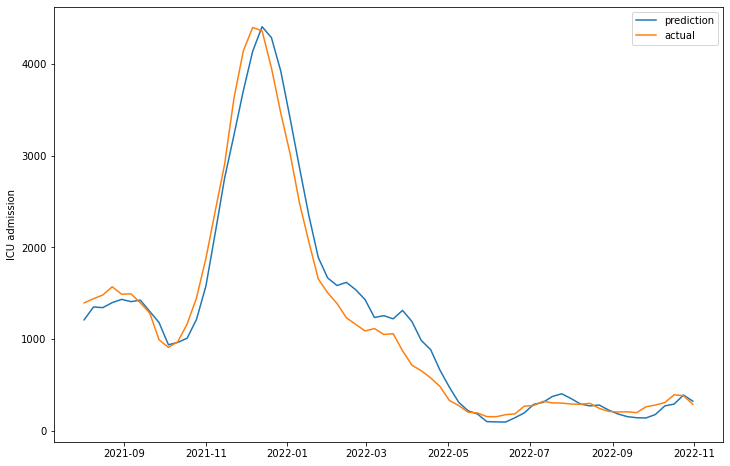

In [34]:
pred_df=pd.DataFrame(table_week.iloc[0,3])
pred_df['actual']=Y_weekinput.iloc[70+1-1:-3].values
pred_df.index=Y_weekinput.index[70+1-1:-3]
plt.figure(figsize=(12,8))
plt.plot(pred_df.iloc[:,0], label='prediction')
plt.plot(pred_df.iloc[:,1], label='actual')
plt.ylabel('ICU admission')
plt.legend()

In [26]:
rmse_w2=sqrt(mean_squared_error(Y_weekinput.iloc[73:-1,:].icu_patients_shift.values,table_week2.iloc[0,5]))
r2_w2=r2_score(Y_weekinput.iloc[73:-1,:].icu_patients_shift.values,table_week2.iloc[0,5])
mae_w2=np.mean(np.abs(Y_weekinput.iloc[73:-1,:].icu_patients_shift.values -  table_week2.iloc[0,5]))

mape_w2=mape(Y_weekinput.iloc[73:-1,:].icu_patients_shift.values,table_week2.iloc[0,5])
print(rmse_w2 )
print(r2_w2)
print(mae_w2)
print(mape_w2)

962.6563646240205
0.30009486013444286
617.2085784205109
0.6578141944895382


In [32]:
rmse_w=sqrt(mean_squared_error(Y_weekinput.iloc[73:,:].icu_patients_shift.values,table_week.iloc[0,6]))
r2_w=r2_score(Y_weekinput.iloc[73:,:].icu_patients_shift.values,table_week.iloc[0,6])
mae_w=np.mean(np.abs(Y_weekinput.iloc[73:,:].icu_patients_shift.values -  table_week.iloc[0,6]))

mape_w=mape(Y_weekinput.iloc[73:,:].icu_patients_shift.values,table_week.iloc[0,6])
print(rmse_w )
print(r2_w)
print(mae_w)
print(mape_w)

1131.5644589352687
0.02710896041336086
706.9922103648952
0.8144702322207515


# daily

In [59]:

train_size=130
model_inputsize=10
forecast_steps=4
num_var=X_dayinput.shape[1]
kernel='rbf'
list1=['temp', 'windspeed', 'new_cases','new_deaths', 'icu_patients', 'hosp_patients' ]
list2=['reproduction_rate', 'case_fatality',  'precip', 'humidity']

scale=StandardScaler()
X_testsize=1
rmse_df_day=[]
model_predictions_day=[]
C= [1,5,10,15,20]
eps=[0.001, 0.005, 0.01, 0.03, 0.05, 0.1]
gamma=[0.0005,0.001, 0.005,0.01,0.03, 0.05, 0.1]
for i in range(len(C)):
    for j in range(len(eps)):
        for k in range(len(gamma)):   
            predictions=traininng_sliding_window(scale,X_dayinput,Y_dayinput, train_size, model_inputsize,forecast_steps, list1, list2, num_var,'rbf',C[i],eps[j], gamma[k], X_testsize)
            dayt=[]
            dayt1=[]
            dayt2=[]
            dayt3=[]
            for n in range(len(predictions)):
                predictions[n]
                dayt.append(predictions[n][0][0])
                dayt1.append(predictions[n][1][0])
                dayt2.append(predictions[n][2][0])
                dayt3.append(predictions[n][3][0])
            model_predictions_day.append(dayt)    
            rmse_test=rmse(Y_dayinput.iloc[train_size+model_inputsize-1:-3,:].hosp_patients_shift.values,dayt)
            mape_test=mape(Y_dayinput.iloc[train_size+model_inputsize-1:-3,:].hosp_patients_shift.values,dayt)
            rmse_df_day.append([C[i],eps[j],gamma[k], rmse_test, mape_test, dayt,Y_dayinput.iloc[train_size+model_inputsize-1:-3,:].hosp_patients_shift.values])
            #rmse_array.append([C[i],eps[j],gamma[k], rmse_test, mape_test])
    #mape_array.append(mape(Y_input.iloc[train_size+model_inputsize-1:-3,:].values,dayt))
    

AttributeError: 'DataFrame' object has no attribute 'hosp_patients_shift'

In [129]:
predictions=traininng_sliding_window(scale,X_dayinput,Y_dayinput,270, 12,4, list1, list2, num_var,'rbf',20,0.001, 0.001, X_testsize)
dayt=[]
dayt1=[]
dayt2=[]
dayt3=[]
for n in range(len(predictions)):
        predictions[n]
        dayt.append(predictions[n][0][0])
        dayt1.append(predictions[n][1][0])
        dayt2.append(predictions[n][2][0])
        dayt3.append(predictions[n][3][0])


In [134]:
Y_dayinput.iloc[270+12-1:-3,:]
len(dayt)

689

In [147]:
mape_test=mape(Y_dayinput.iloc[270+12-1+3:,:].icu_patients_shift.values,dayt3)
rmse=sqrt(mean_squared_error(Y_dayinput.iloc[270+12-1+3:,:].icu_patients_shift.values, dayt3))
R2=r2_score(Y_dayinput.iloc[270+12-1+3:,:].icu_patients_shift.values,dayt3)
mae_test=np.mean(np.abs(Y_dayinput.iloc[270+12-1+3:,:].icu_patients_shift.values -  dayt3))

In [148]:
print(R2)
print(rmse)
print(mae_test)
print(mape_test)

0.9635820929784911
47.17453413748272
27.52944809014223
0.21813463335470362


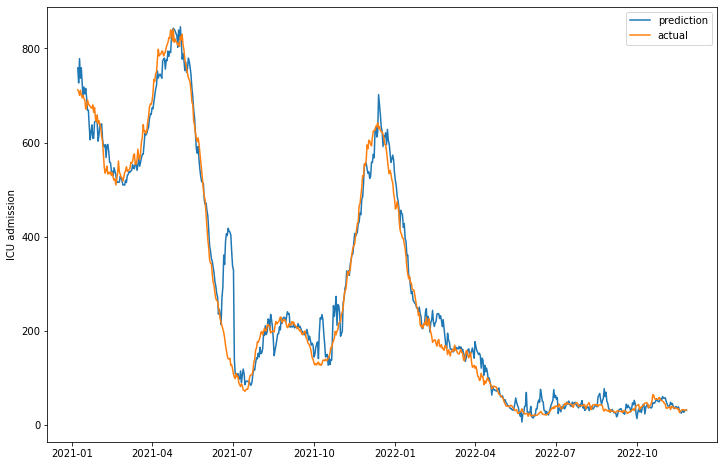

In [150]:
pred_df=pd.DataFrame(dayt)
pred_df['actual']=Y_dayinput.iloc[270+12-1:-3].values
pred_df.index=Y_dayinput.index[270+12-1:-3]
plt.figure(figsize=(12,8))
plt.plot(pred_df.iloc[:,0], label='prediction')
plt.plot(pred_df.iloc[:,1], label='actual')
plt.ylabel('ICU admission')
plt.legend()